In [1]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from pathlib import Path

In [2]:
MODEL_DIR = Path("./notebooks/inceptionv3/models/")
TEST_DIR = Path("./data/test/")
IMG_HEIGHT = IMG_WIDTH = 224
BATCH_SIZE = 128

In [3]:
model_to_load = "iv3_last5.021-0.7856.h5"

In [4]:
model = keras.models.load_model(MODEL_DIR / model_to_load)

In [5]:
test_df = pd.read_csv("./data/test.csv")
test_df.head()

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,43
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,43
2,127f3e6d6e3491b2459812353f33a913.jpg,43
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,43
4,46d681a542f2c71be017eef6aae23313.jpg,43


In [6]:
filepaths = test_df["filename"].map(lambda x: str(TEST_DIR / x))

In [7]:
def load_img(filepath):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH]) 
    return img

In [8]:
test_fp_ds = tf.data.Dataset.from_tensor_slices(filepaths)
for f in test_fp_ds.take(3):
    print(f.numpy())

b'data\\test\\fd663cf2b6e1d7b02938c6aaae0a32d2.jpg'
b'data\\test\\c7fd77508a8c355eaab0d4e10efd6b15.jpg'
b'data\\test\\127f3e6d6e3491b2459812353f33a913.jpg'


In [9]:
test_img_ds = test_fp_ds.map(load_img, num_parallel_calls = tf.data.experimental.AUTOTUNE)
for image in test_img_ds.take(1):
    print("Image shape: ", image.numpy().shape)

Image shape:  (224, 224, 3)


In [10]:
test_img_ds = test_img_ds.batch(BATCH_SIZE)
test_img_ds = test_img_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
one_hot_predictions = model.predict(test_img_ds, batch_size = BATCH_SIZE, verbose = 1)
one_hot_predictions.shape

96/96 [==============================] - 24s 251ms/step


(12186, 42)

In [12]:
predictions = np.argmax(one_hot_predictions, axis = 1)
predictions.shape

(12186,)

In [13]:
test_df["category"] = predictions
test_df["category"] = test_df["category"].map(lambda x: "{:02d}".format(x))

In [14]:
test_df.head()

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,20
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,27
2,127f3e6d6e3491b2459812353f33a913.jpg,04
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,22
4,46d681a542f2c71be017eef6aae23313.jpg,12


In [15]:
test_df.shape

(12186, 2)

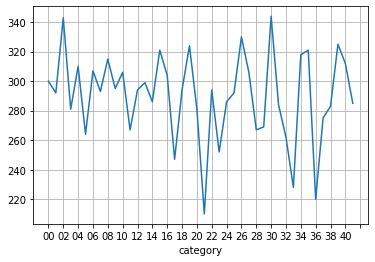

In [16]:
test_df.groupby("category").apply(lambda x: len(x)).plot(grid = True, xticks = [x * 2 for x in range(int(44 / 2))])

In [17]:
test_df.to_csv("./data/predictions_test_2.csv", index = False)